In [25]:
import pandas as pd
import numpy as np

from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Task 2.1.1

In [26]:
customer_df = pd.read_csv("./SMAI-Dataset-customer-dataset/data.csv")

In [27]:
customer_df = (customer_df - customer_df.mean()) / customer_df.std()
customer_df.head()

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,-1.730752,-0.917169,-0.992776,2.652951,1.603922,0.097499,0.296749,1.551938
1,-1.729021,1.089766,1.006773,-1.186835,-0.063357,0.782459,0.296749,1.551938
2,-1.727289,-0.917169,-0.992776,1.117036,-0.063357,-0.832994,-1.269208,-0.909502
3,-1.725557,-0.917169,-0.992776,0.775722,-0.063357,1.328054,0.296749,0.321218
4,-1.723826,-0.917169,-0.992776,1.458351,-0.063357,0.736747,0.296749,0.321218


In [28]:
customer_df = customer_df.drop(customer_df.columns[0], axis=1)
data = customer_df.to_numpy()

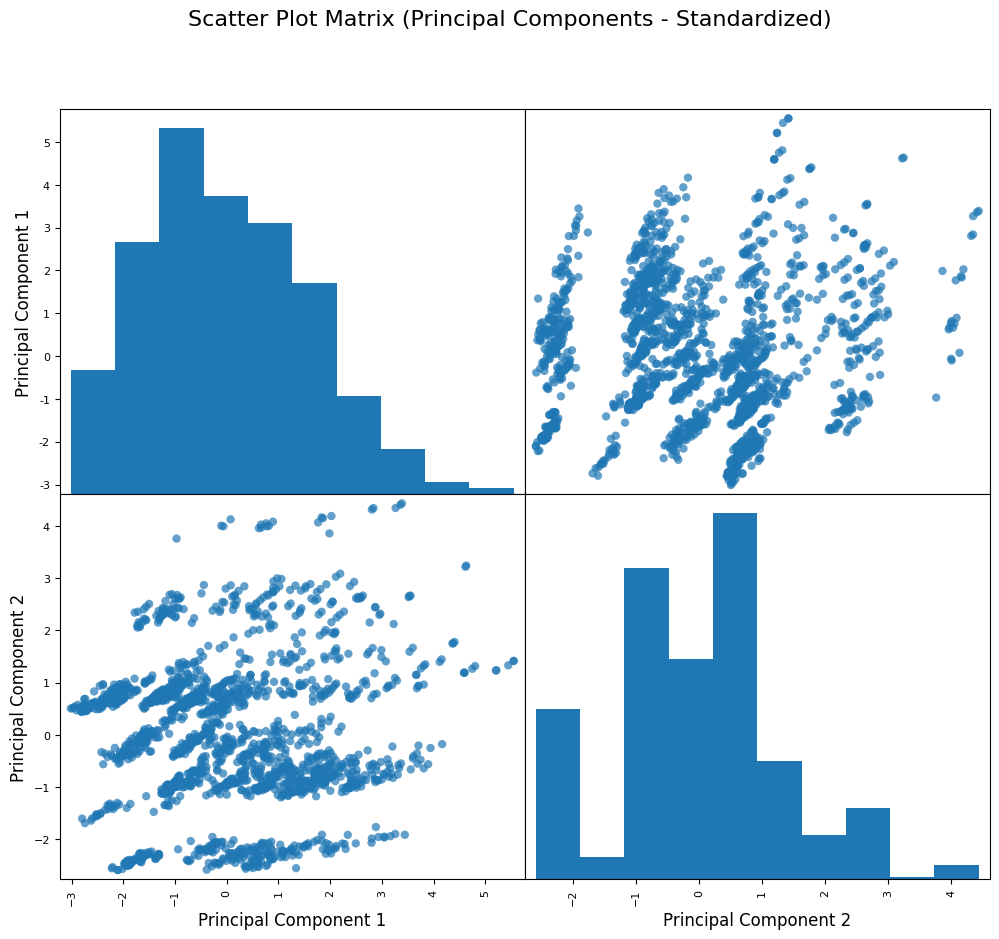

In [29]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)

column_names = ['Principal Component 1', 'Principal Component 2']
df = pd.DataFrame(principal_components, columns=column_names)

scatter_matrix = pd.plotting.scatter_matrix(df, figsize=(12, 10), diagonal='hist', marker='o', alpha=0.7)

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=12, rotation=0)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12, rotation=90)

plt.suptitle('Scatter Plot Matrix (Principal Components - Standardized)', fontsize=16)
plt.show()

In [44]:
class GMM:
    def __init__(self, data, num_clusters=3, iterations=10, tolerance=1e-4):
        self.num_clusters = num_clusters
        self.iterations = iterations
        self.tolerance = tolerance
        self.data = data
        self.log_likelihoods = []
        self.probabilities = []
        
    def initialize_parameters(self):
        self.n_samples, self.n_features = self.data.shape
        kmeans = KMeans(n_clusters=self.num_clusters, random_state=42, n_init=30)
        kmeans.fit(self.data)
        self.means = kmeans.cluster_centers_        
        self.covariances = [np.identity(self.n_features) for _ in range(self.num_clusters)]
        self.weights = np.ones(self.num_clusters) / self.num_clusters
        
    def e_step(self):
        self.membership_values = np.zeros((self.n_samples, self.num_clusters))
        
        for c in range(self.num_clusters):
            self.membership_values[:, c] = self.weights[c] * multivariate_normal.pdf(self.data, self.means[c], self.covariances[c])
            
        self.membership_values /= np.sum(self.membership_values, axis=1, keepdims=True)
        
    def m_step(self):
        total_weight = np.sum(self.membership_values, axis=0)
        
        new_means = np.zeros((self.num_clusters, self.data.shape[1]))
        new_covariances = [np.zeros((self.data.shape[1], self.data.shape[1])) for _ in range(self.num_clusters)]
        new_weights = np.zeros(self.num_clusters)
        
        for c in range(self.num_clusters):
            new_means[c] = np.sum(self.membership_values[:, c][:, np.newaxis] * self.data, axis=0) / total_weight[c]
            diff = self.data - new_means[c]
            new_covariances[c] = (self.membership_values[:, c][:, np.newaxis] * diff).T @ diff / total_weight[c]
            new_weights[c] = total_weight[c] / self.n_samples
            new_covariances[c] += 1e-6 * np.identity(self.data.shape[1])
            
        self.means = new_means
        self.covariances = new_covariances
        self.weights = new_weights
        
    def log_likelihood(self):
        log_lh = 0.0
        
        for i in range(self.n_samples):
            likelihood_i = 0.0
            for c in range(self.num_clusters):
                likelihood_i += self.weights[c] * multivariate_normal.pdf(self.data[i], self.means[c], self.covariances[c])
            log_lh += np.log(likelihood_i)
            
        return log_lh
    
    def aic(self):
        df_per_gaussian = 2 * self.n_features + 1
    
        total_params = self.num_clusters * df_per_gaussian - 1
        log_likelihood = self.log_likelihood()
    
        return -2 * log_likelihood + 2 * total_params

    def bic(self):
        df_per_gaussian = 2 * self.n_features + 1
    
        total_params = self.num_clusters * df_per_gaussian - 1
        log_likelihood = self.log_likelihood()
        n = self.n_samples
        
        return -2 * log_likelihood + total_params * np.log(n)
    
    def silhouette(self):
        cluster_assignments = self.predict()
        score = silhouette_score(self.data, cluster_assignments)
        return score
    
    def fit(self):
        self.initialize_parameters()

        for iteration in range(self.iterations):
            old_means = np.copy(self.means)

            self.e_step()
            self.m_step()

            log_likelihood = self.log_likelihood()
            self.log_likelihoods.append(log_likelihood)

            probabilities = self.membership_values
            self.probabilities.append(probabilities)

            if len(self.log_likelihoods) > 1 and abs(log_likelihood - self.log_likelihoods[-2]) < self.tolerance:
                break
                
    def predict(self):
        cluster_assignments = np.argmax(self.membership_values, axis=1)
        return cluster_assignments

In [38]:
gmm = GMM(data=data, num_clusters=3)

In [39]:
gmm.fit()

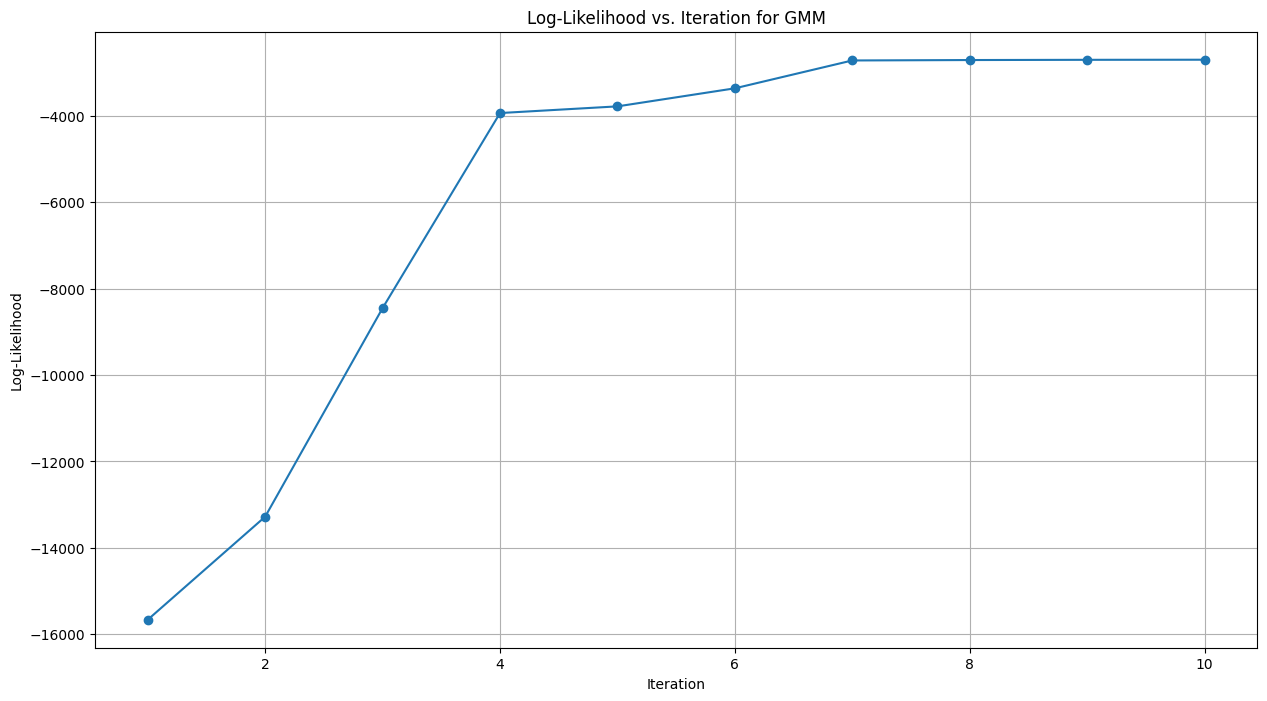

In [40]:
log_likelihoods = gmm.log_likelihoods

plt.figure(figsize=(15, 8))
plt.plot(range(1, len(log_likelihoods) + 1), log_likelihoods, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs. Iteration for GMM')
plt.grid(True)
plt.show()

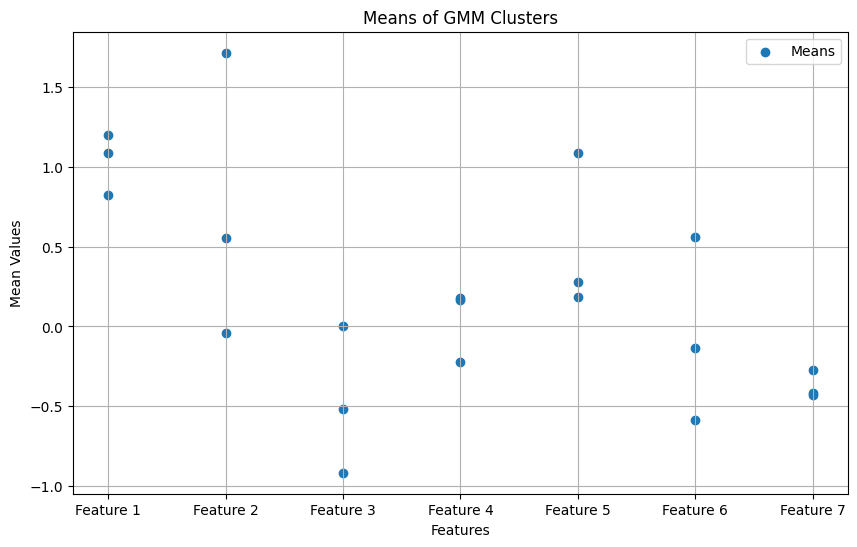

In [41]:
means = gmm.means
means_flat = means.flatten()

n_features = len(means[0])
n_clusters = len(means)
x_values = np.repeat(np.arange(n_features), n_clusters)

plt.figure(figsize=(10, 6))
plt.scatter(x_values, means_flat, marker='o', label='Means')

plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.title('Means of GMM Clusters')
plt.xticks(np.arange(n_features), [f'Feature {i + 1}' for i in range(n_features)])
plt.legend()
plt.grid(True)
plt.show()

In [42]:
cluster_index = 0
mean_cluster_1 = gmm.means[cluster_index]
covariance_cluster_1 = gmm.covariances[cluster_index]
weight_cluster_1 = gmm.weights[cluster_index]

print(f"Mean for Cluster 1: {mean_cluster_1}")
print()
print(f"Covariance for Cluster 1:\n{covariance_cluster_1}")
print()
print(f"Weight for Cluster 1: {weight_cluster_1}")

Mean for Cluster 1: [ 1.0897659   0.82582777  1.19773462  1.71677694  0.55711626 -0.03931864
  0.00219928]

Covariance for Cluster 1:
[[ 1.00000000e-06  2.49350011e-30  3.98617724e-30  5.05210708e-30
   1.29503185e-30  4.39915400e-32  9.36673801e-32]
 [ 2.52516537e-30  3.29068483e-01 -2.95449734e-02 -1.20928740e-02
   1.32040525e-01  1.91122374e-01  1.52623441e-01]
 [ 3.97604436e-30 -2.95449734e-02  9.22288064e-01  4.48987815e-01
  -1.16501674e-01  3.12752809e-02 -1.62002951e-01]
 [ 5.05161280e-30 -1.20928740e-02  4.48987815e-01  6.07335525e-01
  -1.45581662e-01  3.55039913e-02 -4.92310366e-02]
 [ 1.29503185e-30  1.32040525e-01 -1.16501674e-01 -1.45581662e-01
   1.41055540e+00  1.04173849e+00  6.83301980e-01]
 [ 2.81743571e-32  1.91122374e-01  3.12752809e-02  3.55039913e-02
   1.04173849e+00  1.33792492e+00  7.68747694e-01]
 [ 9.36673801e-32  1.52623441e-01 -1.62002951e-01 -4.92310366e-02
   6.83301980e-01  7.68747694e-01  1.01574486e+00]]

Weight for Cluster 1: 0.09974733287250759


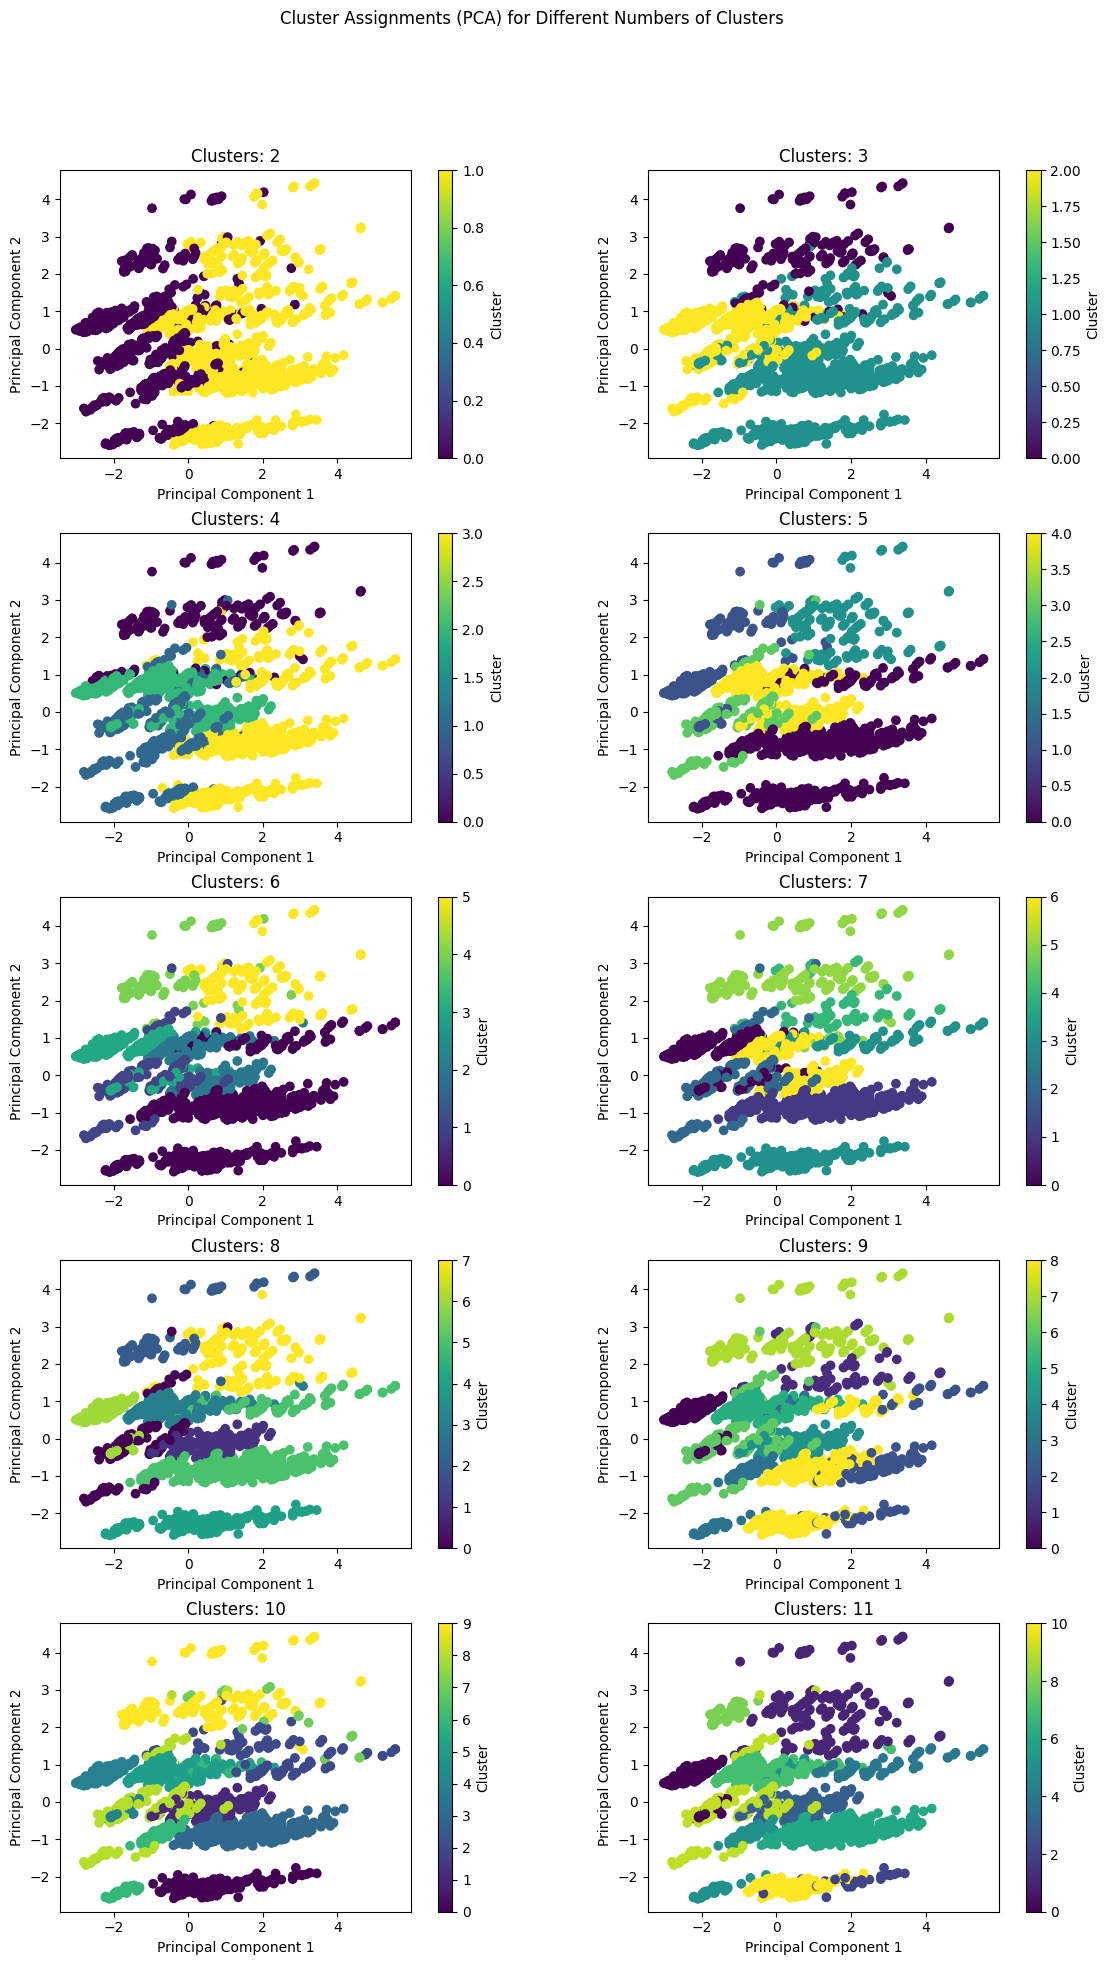

In [43]:
cluster_numbers = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

fig, axs = plt.subplots(5, 2, figsize=(12, 20))
fig.suptitle('Cluster Assignments (PCA) for Different Numbers of Clusters')

for i, num_clusters in enumerate(cluster_numbers):
    gmm = GMM(data, num_clusters=num_clusters, iterations=50, tolerance=1e-4)    
    gmm.fit()
    
    cluster_assignments = gmm.predict()
    
    row = i // 2
    col = i % 2
    scatter = axs[row, col].scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_assignments, cmap='viridis', marker='o')
    axs[row, col].set_title(f'Clusters: {num_clusters}')
    axs[row, col].set_xlabel('Principal Component 1')
    axs[row, col].set_ylabel('Principal Component 2')
    axs[row, col].set_aspect('equal')

    colorbar = plt.colorbar(scatter, ax=axs[row, col])
    colorbar.set_label('Cluster')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Task 2.1.2

In [45]:
wine_data = load_wine()

X = wine_data.data
y = wine_data.target

In [46]:
feature_means = np.mean(X, axis=0)
feature_variances = np.var(X, axis=0)

X_standardized = (X - feature_means) / np.sqrt(feature_variances)

In [47]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)

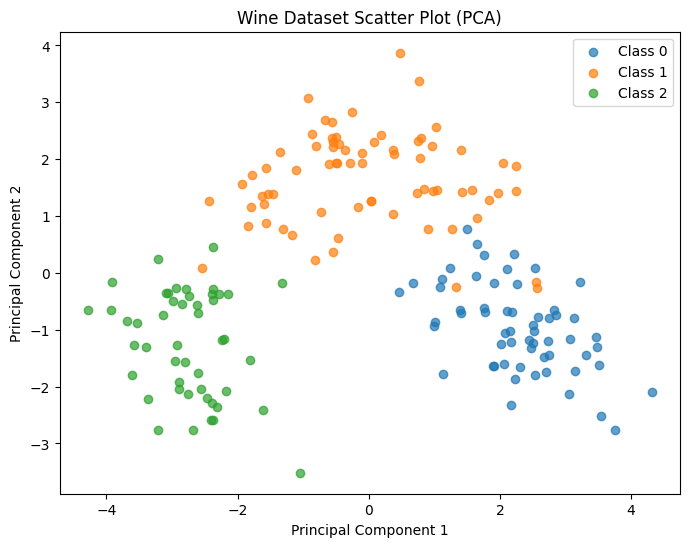

In [48]:
plt.figure(figsize=(8, 6))
for class_label in range(3):
    plt.scatter(X_pca[y == class_label, 0], X_pca[y == class_label, 1], label=f'Class {class_label}', alpha=0.7)

plt.title('Wine Dataset Scatter Plot (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [71]:
n_clusters = range(2, 10)
bic_scores = []
aic_scores = []
silhouette_scores = []
gmm_models = []

for n in n_clusters:
    gmm = GMM(data=X_pca, num_clusters=n, iterations=10, tolerance=1e-4)
    gmm.fit()
    gmm_models.append(gmm)
    
    bic_scores.append(gmm.bic())
    aic_scores.append(gmm.aic())
    silhouette_scores.append(gmm.silhouette())

### Best Clusters (BIC)

In [72]:
min_bic_score = min(bic_scores)
min_bic_index = bic_scores.index(min_bic_score)

best_gmm_cluster_bic = n_clusters[min_bic_index]
best_gmm_bic = gmm_models[min_bic_index]
gmm_cluster_assignments_bic = best_gmm_bic.predict()

### Best Clusters (AIC)

In [73]:
min_aic_score = min(aic_scores)
min_aic_index = aic_scores.index(min_aic_score)

best_gmm_cluster_aic = n_clusters[min_aic_index]
best_gmm_aic = gmm_models[min_aic_index]
gmm_cluster_assignments_aic = best_gmm_aic.predict()

### Best Clusters (Silhoutte)

In [74]:
max_ss_score = max(silhouette_scores)
max_ss_index = silhouette_scores.index(max_ss_score)

best_gmm_cluster_ss = n_clusters[max_ss_index]
best_gmm_ss = gmm_models[max_ss_index]
gmm_cluster_assignments_ss = best_gmm_ss.predict()

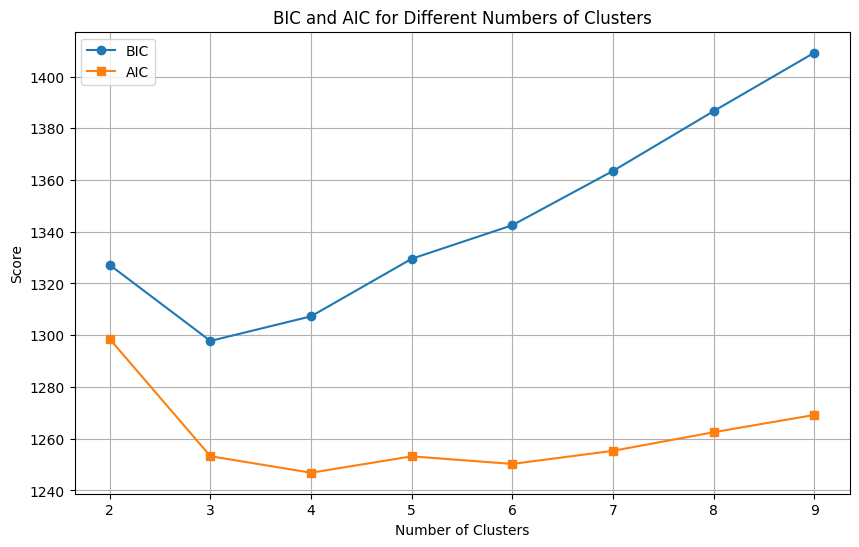

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, bic_scores, marker='o', label='BIC')
plt.plot(n_clusters, aic_scores, marker='s', label='AIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('BIC and AIC for Different Numbers of Clusters')
plt.legend()
plt.grid(True)
plt.show()

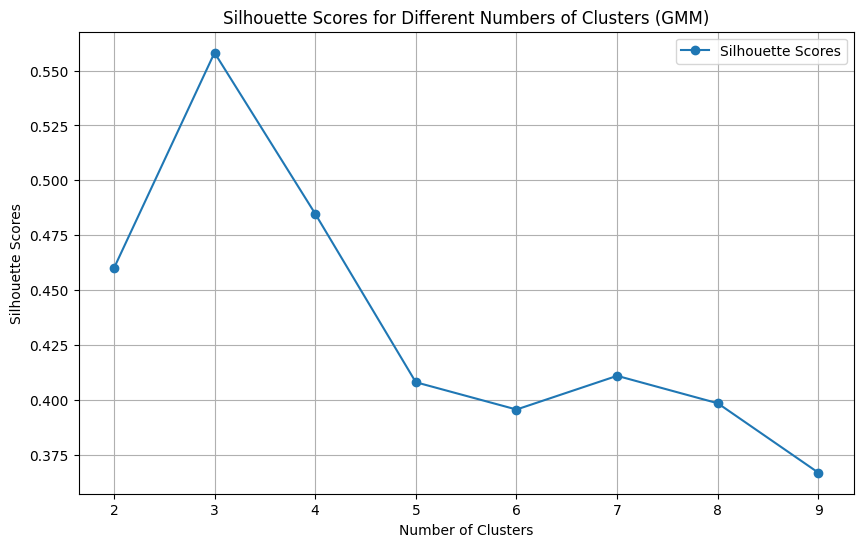

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, silhouette_scores, marker='o', label='Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette Scores for Different Numbers of Clusters (GMM)')
plt.legend()
plt.grid(True)
plt.show()

### Clusters from K-Means

In [77]:
silhouette_scores_kmeans = []
kmeans_models = []

In [78]:
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=1)
    kmeans.fit(X_pca)
    kmeans_models.append(kmeans)
    
    score = silhouette_score(X_pca, kmeans.labels_)
    silhouette_scores_kmeans.append(score)

In [79]:
best_silhouette_score = max(silhouette_scores)
best_silhouette_index = silhouette_scores.index(best_silhouette_score)

best_kmeans_cluster = n_clusters[best_silhouette_index]
best_kmeans = kmeans_models[best_silhouette_index]
kmeans_cluster_assignments = best_kmeans.labels_

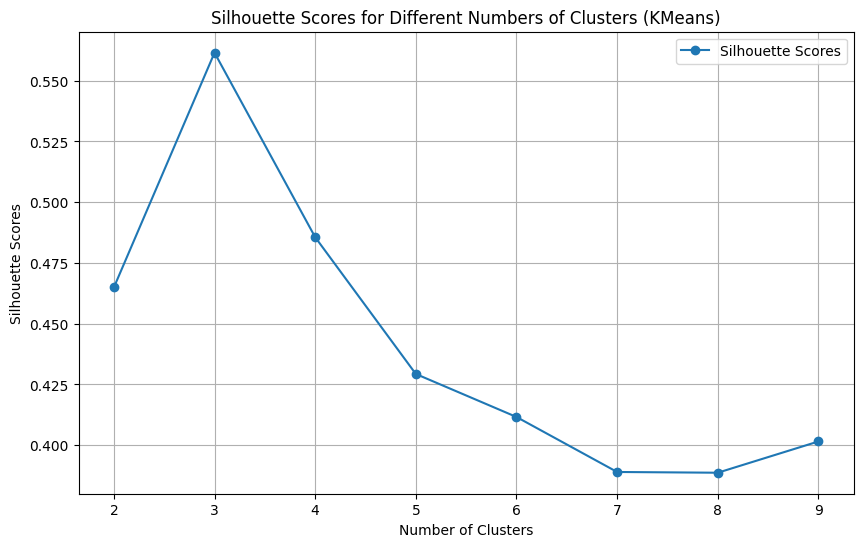

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, silhouette_scores_kmeans, marker='o', label='Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette Scores for Different Numbers of Clusters (KMeans)')
plt.legend()
plt.grid(True)
plt.show()

The Silhouette Scores for 3 clusters are quite similar for both KMeans and GMM, with GMM slightly outperforming KMeans. This result further validates the superior performance of the Gaussian Mixture Model (GMM) in this specific clustering scenario.
The Silhouette Score is maximized, and the number of clusters giving the maximum Silhouette Score is chosen as the optimal clustering.

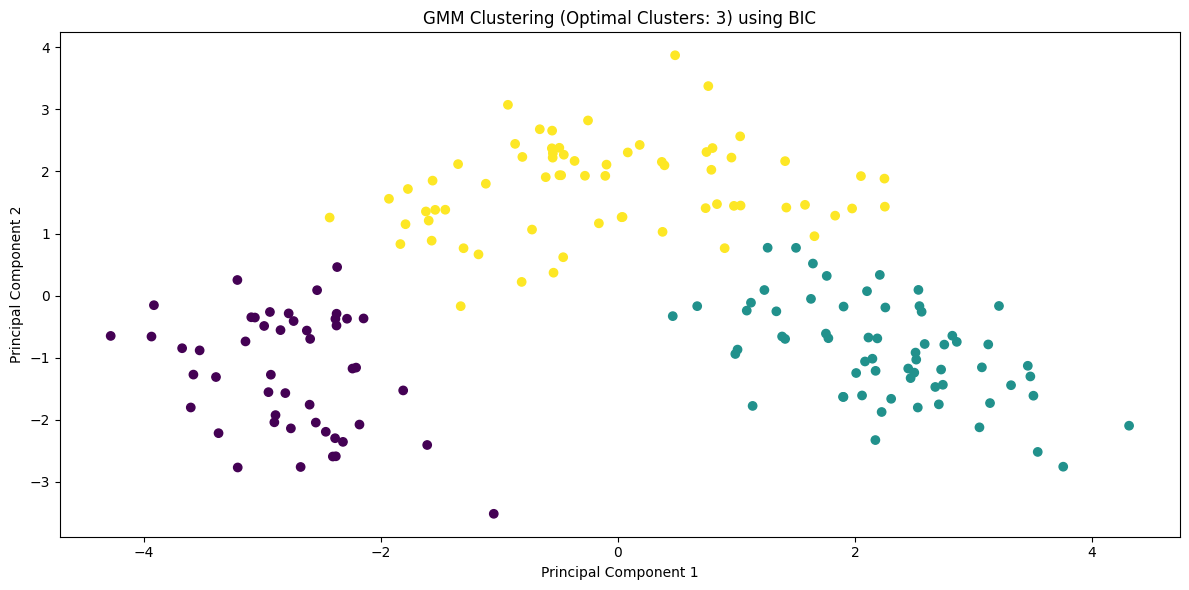

In [81]:
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_cluster_assignments_bic, cmap='viridis', marker='o')
plt.title(f'GMM Clustering (Optimal Clusters: {best_gmm_cluster_bic}) using BIC')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

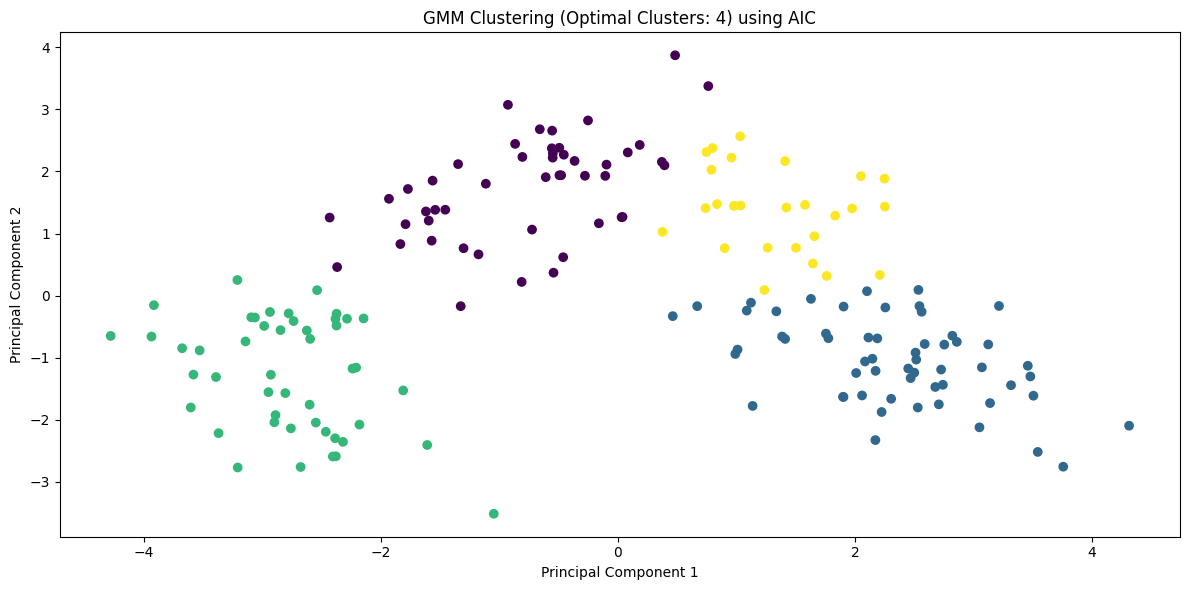

In [84]:
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_cluster_assignments_aic, cmap='viridis', marker='o')
plt.title(f'GMM Clustering (Optimal Clusters: {best_gmm_cluster_aic}) using AIC')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

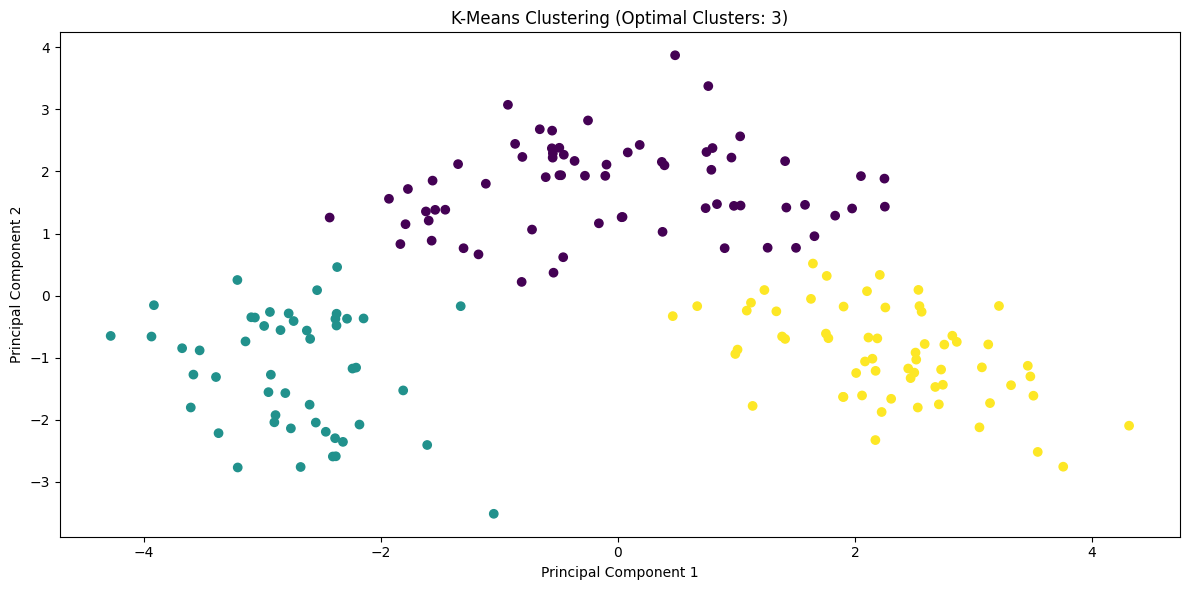

In [83]:
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_cluster_assignments, cmap='viridis', marker='o')
plt.title(f'K-Means Clustering (Optimal Clusters: {best_kmeans_cluster})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

The Optimal Clusters are 3 (given by KMeans and BIC) and 4 (given by AIC). The slight variation in AIC scores between 3 and 4 clusters suggests that while a model with 4 clusters might provide a slightly better fit, the increase in model complexity is not substantial. 
The clustering done on the wine dataset (using AIC, BIC or KMeans) is nearly same, there is not much difference in the points assigned in the clusters